<a href="https://colab.research.google.com/github/Uros-Males/Minimization_Problem_On_Identical_Machines_Analysis/blob/main/NEWNEW_MIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')



df = df[df['n/m']==2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] #cple
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [2]:
y_new = []
cnt0=0
cnt1=0
cnt2=0
cnt3=0
for val in y:
  if(val<10):
    y_new.append(0)
    cnt0+=1
  elif(10 <= val and val<1000):
    y_new.append(1)
    cnt1+=1
  else:
    y_new.append(2)
    cnt2+=1

cnt = 0
if(cnt0>0):
  cnt+=1
if(cnt1>0):
  cnt+=1
if(cnt2>0):
  cnt+=1
if(cnt3>0):
  cnt+=1

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)

In [3]:
names = [ 'av.length', 'n', 'std.dev', 'k', 'm', 'max']
X_modified = X.drop([   'n/m', 'indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n','median', 'min', 'range'], axis = 1)
print(X_modified.head())
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(random_state=0)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)


     n    m   av.length    std.dev  max   k          y
0   40   20  106.199997  52.751087  212  35   1.633244
1  100   50  258.250000  90.268219  398  86   1.643800
2  200  100   57.825001  22.578833  100  75  26.029591
3  120   60   99.541664  21.778059  146  66   6.516763
4  120   60   72.683334  14.145691  100  43   8.168559


In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [5]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()


X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.83)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y', 'k', 'm'], axis = 1)

X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y', 'k', 'm'], axis = 1)
X_test = sc.transform(X_test)

1267
260
        n    m   av.length    std.dev  max   k             y
1362  120   60   93.183334  47.574444  237  87  99999.000000
511   140   70   59.299999  23.383476  100  66     16.941702
9     120   60  107.958336  49.107903  221  91      8.052032
393   200  100   58.500000  23.649662  100  70     25.013287
471   180   90   50.966667  27.984213   99  82     20.236198


In [6]:

from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(8, input_dim = X_modified.shape[1]-3, activation='relu'))

classifier.add(Dense(12, activation = 'relu'))
classifier.add(Dropout(0.125))

#classifier.add(Dense(32, activation = 'relu'))

#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(32, activation = 'relu'))
#classifier.add(Dense(16, activation = 'relu'))

#classifier.add(Dense(16, activation='relu'))

#classifier.add(Dense(8, activation='relu'))

#classifier.add(Dense(12, activation='relu'))

classifier.add(Dense(cnt, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 12)                108       
                                                                 
 dropout (Dropout)           (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 39        
                                                                 
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 64, 
                    epochs = 350, shuffle = True)

Epoch 1/350
20/20 [==============================] - 1s 5ms/step - loss: 1.2168 - accuracy: 0.3339
Epoch 2/350
20/20 [==============================] - 0s 4ms/step - loss: 1.1115 - accuracy: 0.3717
Epoch 3/350
20/20 [==============================] - 0s 2ms/step - loss: 1.0448 - accuracy: 0.4783
Epoch 4/350
20/20 [==============================] - 0s 3ms/step - loss: 0.9872 - accuracy: 0.5359
Epoch 5/350
20/20 [==============================] - 0s 2ms/step - loss: 0.9452 - accuracy: 0.5746
Epoch 6/350
20/20 [==============================] - 0s 3ms/step - loss: 0.9091 - accuracy: 0.5746
Epoch 7/350
20/20 [==============================] - 0s 6ms/step - loss: 0.8718 - accuracy: 0.6188
Epoch 8/350
20/20 [==============================] - 0s 5ms/step - loss: 0.8471 - accuracy: 0.6369
Epoch 9/350
20/20 [==============================] - 0s 5ms/step - loss: 0.8255 - accuracy: 0.6827
Epoch 10/350
20/20 [==============================] - 0s 3ms/step - loss: 0.7988 - accuracy: 0.6961
Epoch 11/

accuracy: 92.69%


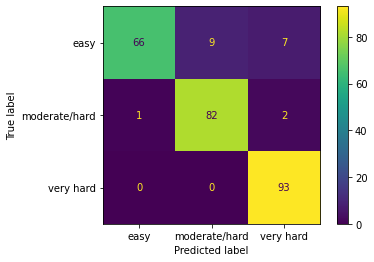

In [8]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])
cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [9]:
column_names = ['n', 'k', 'n/m', 'av.length', 'std.dev', 'y']
df_reg = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': 2, 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)
#VM

260
260


In [10]:
column_names = ['n', 'k', 'm', 'std.dev', 'y']
df_reg0 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'max': X_test_copy.iloc[i]['max'],
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

260
260


In [11]:
column_names = ['n', 'k', 'av.length', 'std.dev', 'm', 'y']
df_reg2 = pd.DataFrame(columns = column_names)
print(X_test_copy.shape[0])
print(len(pred))
for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'm': X_test_copy.iloc[i]['m'],
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

260
260


In [12]:
#IN PROGRESS....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import time
import keras


df = pd.read_csv('/content/sample_data/C-instances-runtime-analysis.csv')




df = df[df['n/m']!=2]

shuffled = df.sample(frac=1).reset_index()

columns_dont_want = [ 'index', 'inst.name','type', 'CPLEXStatus'] 
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
names = ['indeks', 'n', 'n/m', '(n/m)^2', '(n/m)^3', 'm/n', 'av.length', 'std.dev', 'median', 'range', 'min', 'max', 'k']

In [13]:
y_new = []
for val in y:
  if(val<10):
    y_new.append(0)
  elif(10 <= val and val <1000):
    y_new.append(1)
  else:
    y_new.append(2)

shuffled['y_new'] = y_new
y_encoded = shuffled.loc[:,'y_new']
y_new = np.array(y_new)
X_modified = X

In [14]:
from imblearn.over_sampling import RandomOverSampler

names =[ 'std.dev', 'n','n/m', 'max','av.length', 'm', 'k']
X_modified = X.drop([  'median', 'range',  'min','indeks', 'class',  'subtype', '(m/n)^3', '(m/n)^2', '(n/m)^2', '(n/m)^3','m/n'], axis = 1)
X_modified['n/m'] = X_modified['n/m']
#print(X_modified.head())

oversample = RandomOverSampler(random_state=0)
#oversample.fit(X_modified, y_encoded)
X_modified, y_encoded = oversample.fit_resample(X_modified, y_encoded)

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

l_encode = LabelEncoder()
l_encode.fit(y_encoded)
y_encoded = l_encode.transform(y_encoded)
y_encoded = to_categorical(y_encoded)
y_encoded

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [16]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y_encoded, random_state=0, train_size = 0.83)
print(X_train.shape[0])
print(X_test.shape[0])

X_train = X_train.drop(['y',  'm'], axis = 1)
X_train = sc.fit_transform(X_train)
X_test_copy = X_test
print(X_test_copy.head())
X_test = X_test.drop(['y',  'm'], axis = 1)
X_test = sc.transform(X_test)

11401
2336
         n   m    n/m  av.length    std.dev  max   k           y
3234    22   2  11.00  56.772728  23.439753   98  20    2.045761
4495   180  72   2.50  58.877777  23.254639   99  71   44.752888
10982   22   8   2.75  55.454544  21.522364   88  21    0.667351
9657    22   2  11.00  63.136364  24.030329   97  20    6.672431
5976    54   6   9.00  93.296295  47.311745  219  46  100.862305


In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()
classifier.add(Dense(16, input_dim = X_modified.shape[1]-2, activation='relu'))

classifier.add(Dropout(0.2))

classifier.add(Dense(3, activation = 'softmax'))
classifier.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                112       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 163
Trainable params: 163
Non-trainable params: 0
_________________________________________________________________


In [18]:
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 25, 
                                        restore_best_weights = True)
  
history = classifier.fit(X_train, y_train, batch_size = 32, 
                    epochs = 120)

Epoch 1/120
357/357 [==============================] - 1s 2ms/step - loss: 0.6668 - accuracy: 0.7327
Epoch 2/120
357/357 [==============================] - 1s 2ms/step - loss: 0.4387 - accuracy: 0.8329
Epoch 3/120
357/357 [==============================] - 1s 1ms/step - loss: 0.3913 - accuracy: 0.8453
Epoch 4/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3731 - accuracy: 0.8570
Epoch 5/120
357/357 [==============================] - 1s 1ms/step - loss: 0.3569 - accuracy: 0.8621
Epoch 6/120
357/357 [==============================] - 1s 1ms/step - loss: 0.3519 - accuracy: 0.8640
Epoch 7/120
357/357 [==============================] - 1s 1ms/step - loss: 0.3416 - accuracy: 0.8703
Epoch 8/120
357/357 [==============================] - 1s 1ms/step - loss: 0.3344 - accuracy: 0.8697
Epoch 9/120
357/357 [==============================] - 1s 1ms/step - loss: 0.3320 - accuracy: 0.8704
Epoch 10/120
357/357 [==============================] - 1s 2ms/step - loss: 0.3261 - accura

accuracy: 91.31%


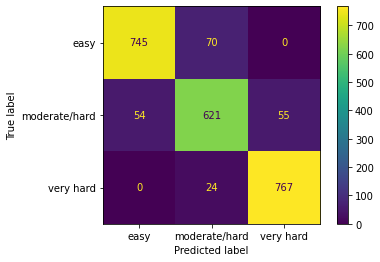

In [19]:
from keras.metrics import accuracy
pred = classifier.predict(X_test)
pred_ = np.argmax(pred, axis = 1)
pred_ = l_encode.inverse_transform(pred_)

true_y = l_encode.inverse_transform(np.argmax(to_categorical(y_test), axis = 1)[:,1])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_y, pred_, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(cm, display_labels=['easy','moderate/hard', 'very hard'])

cmd.plot()

cnt = 0
cnt_correct = 0
for i in range(len(pred)):
  cnt += 1
  if(pred_[i] == true_y[i]):
    cnt_correct += 1
print(f'accuracy: {(cnt_correct/cnt)*100:.2f}%')

In [20]:
for i in range(len(pred)):
  if(pred_[i] == 1):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'n/m': X_test_copy.iloc[i]['n/m'], 
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg = df_reg.append(dictionary, ignore_index = True)

for i in range(len(pred)):
  if(pred_[i] == 0):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'max': X_test_copy.iloc[i]['max'],
                  'm' : X_test_copy.iloc[i]['m'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg0 = df_reg0.append(dictionary, ignore_index = True)
#EASY

for i in range(len(pred)):
  if(pred_[i] == 2):
    dictionary = {'n' : X_test_copy.iloc[i]['n'], 'm': X_test_copy.iloc[i]['m'],
                  'av.length' : X_test_copy.iloc[i]['av.length'], 'std.dev' : X_test_copy.iloc[i]['std.dev'],
                  'k' : X_test_copy.iloc[i]['k'], 'y': X_test_copy.iloc[i]['y']}
    df_reg2 = df_reg2.append(dictionary, ignore_index = True)

#VHARD

In [21]:
print(df_reg.shape[0])
print(df_reg.head(500))

806
         n      k   n/m   av.length     std.dev           y
0    140.0   66.0  2.00   59.299999   23.383476   16.941702
1    200.0   70.0  2.00   58.500000   23.649662   25.013287
2    180.0   82.0  2.00   50.966667   27.984213   20.236198
3    180.0   48.0  2.00   73.844444   14.182301   15.753226
4    180.0   65.0  2.00  100.033333   19.230997   11.714540
..     ...    ...   ...         ...         ...         ...
495  126.0  110.0  2.25  510.690491  131.463486   45.359486
496  198.0   79.0  4.50   99.363640   21.138391  166.733978
497  126.0   61.0  9.00   60.611111   25.273851  222.819443
498  160.0   68.0  2.50   98.612503   18.766016   69.625435
499   72.0   61.0  3.00  182.583328   59.445026   28.031887

[500 rows x 6 columns]


In [22]:
print(df_reg0.head())

       n      k     m     std.dev         y    max
0  120.0   91.0  60.0   49.107903  8.052032  221.0
1  120.0  105.0  60.0  112.438736  1.723558  718.0
2   80.0   53.0  40.0   24.449776  6.197287  100.0
3  140.0   49.0  70.0   13.985677  9.729861  100.0
4  100.0   46.0  50.0   14.846271  3.174622  100.0


In [23]:
print(df_reg2.head())

       n      k   av.length     std.dev      m             y
0  120.0   87.0   93.183334   47.574444   60.0  99999.000000
1  180.0  146.0  733.322205  171.986023   90.0      5.651948
2  160.0  133.0  652.887512  156.741806   80.0  99999.000000
3  120.0   93.0   99.625000   48.803493   60.0  99999.000000
4  200.0  119.0  101.699997   49.112724  100.0  99999.000000


In [47]:
for i in range(df_reg.shape[0]):
  if(df_reg.iloc[i]['y'] >1000):
    df_reg.loc[i, 'y'] = 1001

for i in range(df_reg0.shape[0]):
  if(df_reg0.iloc[i]['y'] > 10):
    df_reg0.loc[i, 'y'] = 11

for i in range(df_reg2.shape[0]):
  if(df_reg2.iloc[i]['y'] == 99999):
    df_reg2.loc[i, 'y'] = 4510


print(df_reg['y'].max())
shuffled = df_reg.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

1001.0


In [48]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
tmp = tmp.sample(frac = 1).reset_index()
print(tmp.head(60))
#y = np.log10(tmp['y']*10)+20
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

6000
6000
    index      n      k    n/m   av.length     std.dev     y
0    2121  100.0   86.0   2.50  237.240005   83.270164    79
1    4300  100.0   79.0   5.00  106.940002   51.632111   263
2    2555   44.0   34.0  11.00  176.659088   29.428621   103
3      78  140.0  118.0   2.50  345.614288  128.611115   278
4    1458  160.0   78.0   2.50   53.724998   29.127333    45
5    1092  126.0   63.0   6.00   63.706348   23.406693    22
6    4719   90.0   58.0   9.00   55.355556   29.830725   314
7    1936  220.0  127.0   2.75  101.918182   45.567780    70
8    1594   80.0   50.0   5.00   98.437500   22.646902    53
9    1520  140.0   60.0   5.00   99.935715   19.174026    49
10   5939  126.0   62.0   9.00   62.365078   22.095287   938
11   4755  200.0   78.0   5.00   97.915001   20.192238   316
12   1185  126.0   64.0   3.00   98.142860   19.738577    29
13   2647  160.0   70.0   5.00   98.637497   19.488903   108
14   4039   90.0   60.0   6.00   92.699997   21.933220   232
15   1125   72

In [49]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer="Adam")
    return model

In [50]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


78/78 [==============================] - 1s 2ms/step - loss: 2118842.0000
Epoch 2/300
78/78 [==============================] - 0s 2ms/step - loss: 294226.5938
Epoch 3/300
78/78 [==============================] - 0s 2ms/step - loss: 93759.2891
Epoch 4/300
78/78 [==============================] - 0s 2ms/step - loss: 63279.2656
Epoch 5/300
78/78 [==============================] - 0s 2ms/step - loss: 54365.7695
Epoch 6/300
78/78 [==============================] - 0s 2ms/step - loss: 47339.9922
Epoch 7/300
78/78 [==============================] - 0s 2ms/step - loss: 42630.2305
Epoch 8/300
78/78 [==============================] - 0s 2ms/step - loss: 39513.4766
Epoch 9/300
78/78 [==============================] - 0s 2ms/step - loss: 36372.5352
Epoch 10/300
78/78 [==============================] - 0s 2ms/step - loss: 34125.2109
Epoch 11/300
78/78 [==============================] - 0s 2ms/step - loss: 30782.9043
Epoch 12/300
78/78 [==============================] - 0s 2ms/step - loss: 29609.162

In [51]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

16/16 [==============================] - 0s 1ms/step
r_square score:  0.9141817042729382
RMSE:


62.131134943065454

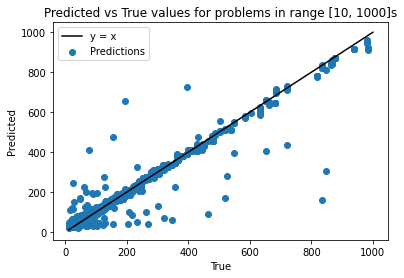

In [52]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>=10 and yy[i]<1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(10, 1000, 2000)
y = x
plt.title('Predicted vs True values for problems in range [10, 1000]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x, y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])

In [53]:
shuffled = df_reg0.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [54]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

3520
3520
        n      k     m     std.dev    max   y
0    22.0   18.0   8.0   19.809536   87.0   0
1    36.0   30.0  16.0   28.115902   97.0   0
2    18.0   18.0   2.0   27.304863   96.0   0
3    20.0   19.0  10.0   46.684017  186.0   0
4    40.0   33.0  10.0   27.823807   98.0   6
5    40.0   29.0  10.0   16.884525  130.0   4
6    20.0   16.0   5.0   11.834272   97.0   0
7    40.0   31.0  10.0   15.438131   99.0   7
8    60.0   45.0  24.0   29.713789   99.0   4
9    44.0   38.0  16.0   45.379253  292.0   5
10  120.0  109.0  60.0  124.065346  781.0   3
11   20.0   18.0   8.0   21.353172   85.0   0
12   20.0   15.0   8.0   23.430693   95.0   0
13   40.0   33.0  20.0   24.502106   99.0   1
14   20.0   20.0   2.0   13.862007   99.0   8
15   18.0   18.0   3.0   55.454536  206.0   0
16   18.0   17.0   6.0   22.994246   96.0   0
17   44.0   43.0  16.0   43.853661  179.0  11
18   36.0   30.0  12.0   28.370382   91.0   2
19   20.0   17.0   8.0   18.093033   78.0   0
20   20.0   18.0   8.0  

In [55]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 10*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(8, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(12, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [56]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=300, batch_size=64, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


46/46 [==============================] - 1s 1ms/step - loss: 9.5841
Epoch 2/300
46/46 [==============================] - 0s 2ms/step - loss: 7.1436
Epoch 3/300
46/46 [==============================] - 0s 2ms/step - loss: 5.4010
Epoch 4/300
46/46 [==============================] - 0s 2ms/step - loss: 4.0816
Epoch 5/300
46/46 [==============================] - 0s 2ms/step - loss: 3.6004
Epoch 6/300
46/46 [==============================] - 0s 2ms/step - loss: 3.1680
Epoch 7/300
46/46 [==============================] - 0s 2ms/step - loss: 2.9772
Epoch 8/300
46/46 [==============================] - 0s 2ms/step - loss: 2.7552
Epoch 9/300
46/46 [==============================] - 0s 2ms/step - loss: 2.5645
Epoch 10/300
46/46 [==============================] - 0s 2ms/step - loss: 2.4524
Epoch 11/300
46/46 [==============================] - 0s 2ms/step - loss: 2.4051
Epoch 12/300
46/46 [==============================] - 0s 2ms/step - loss: 2.2871
Epoch 13/300
46/46 [=============================

In [57]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

10/10 [==============================] - 0s 2ms/step
r_square score:  0.8962449261184552
RMSE:


1.0857032356845078

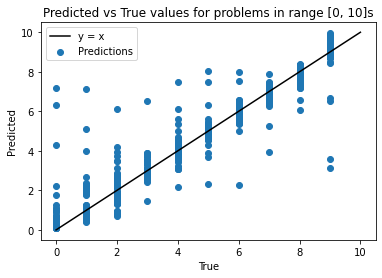

In [58]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]<10):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(0, 10, 100)
y = x
plt.title('Predicted vs True values for problems in range [0, 10]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])

In [59]:
shuffled = df_reg2.sample(frac=1).reset_index()

columns_dont_want = ['y', 'index', 'inst.name','type', 'CPLEXStatus']
select = [x for x in shuffled.columns if x not in columns_dont_want]

X = shuffled.loc[:, select]

y = shuffled.loc[:,'y']
X_modified = X

In [60]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(random_state=0)
X_modified, y = oversample.fit_resample(X_modified, y.astype('int'))
print(X_modified.shape[0])

from imblearn.over_sampling import SMOTE

smote_on_3 = 50
#oversample = SMOTE(sampling_strategy={99999:50000})
#X_modified, y = oversample.fit_resample(X_modified, y)
print(X_modified.shape[0])

tmp = X_modified
tmp['y'] = y
print(tmp.head(60))
tmp = tmp.sample(frac = 1).reset_index()
#y = np.log10(tmp['y']*10)+20
tmp = tmp.dropna()
y = tmp['y']
X_modified = tmp.drop(['y'], axis = 1)

147392
147392
        n      k   av.length     std.dev     m     y
0   180.0   72.0   99.150002   19.391722  30.0  1234
1   140.0   67.0   59.092857   22.890703  14.0  1696
2   180.0   48.0   73.844444   14.182301  18.0  4510
3   198.0  172.0  504.227264  164.906067  44.0  4510
4    88.0   75.0   99.193184   48.846195   8.0  2028
5   198.0   73.0   61.944443   24.128296  18.0  1316
6   200.0  125.0  101.815002   50.574791  20.0  4510
7   120.0  103.0  296.191681  111.699722  60.0     4
8   176.0  147.0  698.954529  173.217331  64.0  4510
9   180.0   50.0   75.622223   14.227270  18.0  4510
10  180.0   48.0   73.844444   14.182301  18.0  4510
11  140.0  121.0  565.914307  141.513672  14.0  4510
12  144.0  124.0  565.680542  146.309006  32.0  4510
13  180.0  113.0  102.633331   46.883411  20.0  4510
14  110.0   44.0   74.636360   14.576421  10.0   750
15  162.0  136.0  399.481476  136.154510  54.0  1092
16  180.0  155.0  452.866669  158.482986  20.0  4510
17  132.0   88.0  111.189392   4

In [61]:
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import tensorflow as tf
from tensorflow import keras 
from tensorflow.python.ops import math_ops


def custom_activation(x):
    #return K.relu(tensorflow.subtract(x,-1)) - K.relu(tensorflow.subtract(x,3.5))
    return 4510*1/(1+K.exp(-x))


get_custom_objects().update({'custom_activation': Activation(custom_activation)})

def make_model():
    model = Sequential()
    
    model.add(Dense(16, input_dim=X_modified.shape[1], activation='relu'))
    #model.add(Dropout(0.25))
    
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(0.1))

    model.add(Dense(16, activation = 'relu'))

    model.add(Dense(4, activation = 'relu'))

    model.add(Dense(1, activation = custom_activation))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [62]:
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc2 = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X_modified, y, random_state=0, train_size = 0.83)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, train_size = 0.83)


X_train = sc.fit_transform(X_train)
X_test_copy = X_test
X_test = sc.transform(X_test)
#X_val = sc.transform(X_val)

#y_train = sc2.fit_transform(y_train.values.reshape(-1,1))
#y_test = sc2.transform(y_test.values.reshape(-1,1))

estimator = KerasRegressor(build_fn=make_model, epochs=60, batch_size=128, verbose=1)

#history=estimator.fit(X_train,y_train)
from keras.metrics import accuracy
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)
  
history = estimator.fit(X_train, y_train, shuffle = True)
#plt.plot(history.history['val_accuracy'])

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


956/956 [==============================] - 2s 2ms/step - loss: 140464.2812
Epoch 2/60
956/956 [==============================] - 2s 2ms/step - loss: 60056.4102
Epoch 3/60
956/956 [==============================] - 2s 2ms/step - loss: 45612.0352
Epoch 4/60
956/956 [==============================] - 2s 2ms/step - loss: 31562.1562
Epoch 5/60
956/956 [==============================] - 2s 2ms/step - loss: 25614.1250
Epoch 6/60
956/956 [==============================] - 2s 2ms/step - loss: 22744.4238
Epoch 7/60
956/956 [==============================] - 2s 2ms/step - loss: 20709.2617
Epoch 8/60
956/956 [==============================] - 3s 3ms/step - loss: 20178.3730
Epoch 9/60
956/956 [==============================] - 2s 2ms/step - loss: 18599.7402
Epoch 10/60
956/956 [==============================] - 2s 2ms/step - loss: 18446.7715
Epoch 11/60
956/956 [==============================] - 2s 2ms/step - loss: 18503.5332
Epoch 12/60
956/956 [==============================] - 2s 2ms/step - loss

In [63]:
from sklearn.metrics import r2_score
prediction = estimator.predict(X_test)
print("r_square score: ", r2_score(y_test,prediction))
#y_test = sc2.inverse_transform(y_test.reshape(-1,1))
yy = np.array(y_test)
#yy = np.power(yy, 10)/10
#prediction = sc2.inverse_transform(prediction.reshape(-1,1))
predd = np.array(prediction)
#predd = np.power(predd, 10)/10

from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:")
sqrt(mean_squared_error(yy, predd))

196/196 [==============================] - 0s 1ms/step
r_square score:  0.9907290234792632
RMSE:


108.81212675935376

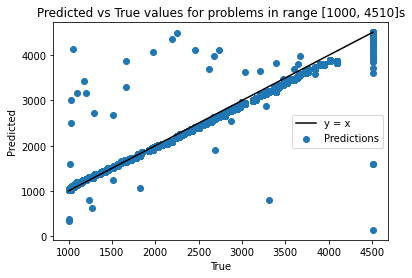

In [64]:
yy_temp = []
predd_temp = []

for i in range(len(yy)):
  if(yy[i]>1000):
    yy_temp.append(yy[i])
    predd_temp.append(predd[i])

x = np.linspace(1000, 4510, 2000)
y = x

plt.title('Predicted vs True values for problems in range [1000, 4510]s')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.plot(x,y, color = 'black')
plt.scatter(yy_temp, predd_temp)
plt.legend(['y = x', 'Predictions'])